<h1> Dependências

In [25]:
import pandas as pd
import numpy as np 

<h1>Carregando Dados

In [5]:
actions = pd.read_csv('ActionList-Reduced.csv')
#Setting time column from string to Float
actions['Time'] = actions['Time'].apply(lambda x: x.replace(',','.')).astype(float)

ref = pd.read_csv('RefPostos-Reduced.csv')
ref = ref.drop(columns=['Classe Posto','Ordem Atividades','Parte'])
#Setting time column from string to Float
ref['Tempo (s)'] = ref['Tempo (s)'].apply(lambda x: x.replace(',','.')).astype(float)

operators = pd.read_csv('Operadores-Reduced.csv')

<h2> Referencia

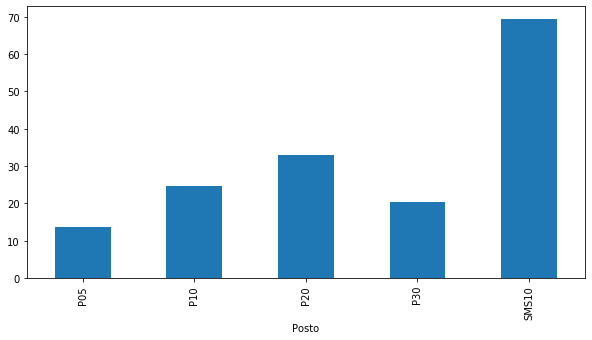

In [6]:
#Graph for referential comparison data
ref.groupby('Posto')['Tempo (s)'].sum().plot(kind="bar", figsize=(10,5))

<h1> Estado Inicial

Iniciando TT com o valor inteiro arredondado para cimada ação mais demorada da lista de ações e definindo a sequência inicial como a ordem dos operadores no arquivo de entrada.

In [7]:
def getInitialTT():
    return math.ceil(max(actions.Time))

In [26]:
def getFirstOperatorsOrder():
    
    order = []
    
    for i in range(0,len(operators.Nome)):
        order = np.append(order, i)
        
    return order

In [9]:
def getStateNumber(state):
    state_number = 0
    
    state_number = state_number + state[0]*6**5
    
    state_number = state_number + state[1]*1
    state_number = state_number + state[2]*6**1
    state_number = state_number + state[3]*6**2
    state_number = state_number + state[4]*6**3
    state_number = state_number + state[5]*6**4
    
    return int(state_number)

In [54]:
def plotGraph(tt,order): 

    #Definindo tempo total somado das atividades
    total_time = actions.Time.sum()

    #Definindo a distribuição sequencial baseada em TT e order
    accumulator = 0
    full_time = 0
    time_posto = [0] * len(operators.Nome)
    index = 0
    action_num = 0

    while(action_num < len(actions.Time)-1 and index < len(operators.Nome)):

        while accumulator < tt-actions.Time[action_num]*operators.Eficiencia[order[index]]:
            if(action_num < len(actions.Time)-1):
                accumulator = accumulator + actions.Time[action_num]*operators.Eficiencia[order[index]]
                action_num = action_num + 1
            else:
                break

        time_posto[index] = accumulator 
        full_time = full_time + accumulator
        accumulator = 0
        index = index + 1
        
    missing_actions = len(actions.Time)-1 - action_num 
    not_working_operators = len(operators.Nome) - np.count_nonzero(time_posto)
    mean_time = time_posto[time_posto!=0].mean()
    max_time = np.max(time_posto)

    #Printa valores de saída se flag acionada
    
    print('INPUT')
    print(f'Tempo Maximo/Posto: {tt}')
    print(f'Ordem dos Operadores: {order}')
    print('')
    print('OUTPUT')
    print(f'Ações faltando: {missing_actions}')
    print(f'Operadores sem Trabalho: {not_working_operators}')
    print(f'Tempo Maximo no posto: {max_time}')

    print('')

   # print(f'SCORE: {getEvaluation(missing_actions,not_working_operators,max_time)}')
    
    pd.DataFrame(time_posto).plot(kind="bar",figsize=(10,5),legend=0)

In [29]:
def get_reward(state):

        total_time = state[0]
        order = state[1:len(state)-1]

        #Definindo a distribuição sequencial baseada em TT e order
        accumulator = 0
        full_time = 0
        time_posto = [0] * (len(state)-1)
        index = 0
        action_num = 0

        while(action_num < len(actions.Time)-1 and index < len(operators.Nome)):

            while accumulator < state[0]-actions.Time[action_num]*operators.Eficiencia[order[index-1]]:
                if(action_num < len(actions.Time)-1):
                    accumulator = accumulator + actions.Time[action_num]*operators.Eficiencia[order[index-1]]
                    action_num = action_num + 1
                else:
                    break

            time_posto[index] = accumulator 
            full_time = full_time + accumulator
            accumulator = 0
            index = index + 1

        missing_actions = len(actions.Time)-1 - action_num 
        not_working_operators = len(operators.Nome) - np.count_nonzero(time_posto)
        mean_time = time_posto[time_posto!=0].mean()
        max_time = np.max(time_posto)

        if(missing_actions > 0 or not_working_operators > 0):
            return 0
        else:
            return max_time

<h1>Ambiente

In [12]:
from enums import *
import random

class LayoutSimulation:
    
    #def __init__(self, tt=np.max(actions.Time),order = getFirstOperatorsOrder()):   

    def take_action(self, action):
        if action == 'INCREASE':
            self.state[0] = self.state[0] + 1
            reward = get_reward(self.state)
        elif action == 'DECREASE':
            self.state[0] = self.state[0] - 1
            reward = get_reward(self.state)
        else:
            aux = self.state[1]
            self.state[1] = self.state[action]
            self.state[action] = aux
            reward = get_reward(self.state)
            
        return self.state, reward

    def reset(self):
        # Reset state to zero, the beginning of the dungeon
        self.state = np.concatenate(([getInitialTT()],getFirstOperatorsOrder()))
        return self.state

<h1>Agente

In [22]:
from enums import *
import random
import math

class Supervisor:
    def __init__(self, learning_rate=0.1, discount=0.95, exploration_rate=1.0, iterations=10000):
        #self.q_table = [ [ 0 for i in range(100*math.factorial(len(operators.Nome))) ] for j in range(len(operators.Nome)+1)] # Spreadsheet (Q-table) for rewards accounting
        self.q_table = [ [ 0 for i in range(len(operators.Nome)+1) ] for j in range(785376)]
        self.learning_rate = learning_rate # How much we appreciate new q-value over current
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = 1.0 # Initial exploration rate
        self.exploration_delta = 1.0 / iterations # Shift from exploration to exploitation

    def get_next_action(self, state):
        if random.random() > self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.greedy_action(state)
        else:
            return self.random_action()

    def greedy_action(self, state):
        
        # Choose best rewarding action to take
        #print(f'{state},{getStateNumber(state)}')
        #print(f'{self.q_table[10][5]}')
        
        best_action = np.max(self.q_table[getStateNumber(state)])
        
        if best_action == 0:
            return 'INCREASE'
        if best_action == 1:
            return 'DECREASE'
        else:
            return best_action

    def random_action(self):
        rand = random.randint(0, len(operators.Nome))
        if(rand == 0):
            return 'INCREASE'
        if(rand == 1):
            return 'DECREASE'
        else:
            return rand

    def update(self, old_state, new_state, action, reward):
        # Old Q-table value
        
        #print(f'{action} , {getStateNumber(old_state)}')
        old_value = self.q_table[getStateNumber(old_state)][action]
        # What would be our best next action?
        future_action = self.greedy_action(new_state)
        
        if(future_action == 'INCREASE'):
            future_action = 0
        if(future_action == 'DECREASE'):
            future_action = 1
            
        # What is reward for the best next action?
        print(f'{getStateNumber(new_state)}, {future_action}')
        future_reward = self.q_table[getStateNumber(new_state)][future_action]

        # Main Q-table updating algorithm
        print(f'Old: {old_value}')
        new_value = old_value + self.learning_rate * (reward + self.discount * future_reward - old_value)
        self.q_table[getStateNumber(old_state)][action] = new_value

        # Finally shift our exploration_rate toward zero (less gambling)
        if self.exploration_rate > 0:
            self.exploration_rate -= self.exploration_delta

<h1>Simulação

In [14]:
import random
import json
import argparse
import time

def SimulationStart():
    # parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--learning_rate', type=float, default=0.1, help='How quickly the algorithm tries to learn')
    parser.add_argument('--discount', type=float, default=0.95, help='Discount for estimated future action')
    parser.add_argument('--iterations', type=int, default=2000, help='Iteration count')
    FLAGS, unparsed = parser.parse_known_args()

    agent = Supervisor()

    # setup simulation
    line_layout = LayoutSimulation()
    tt = getInitialTT()
    order = getFirstOperatorsOrder()
    line_layout.reset()
    total_reward = 0 # Score keeping

    print(f'Estado Inicial: {line_layout.state}')
    print('\n')
    #Main loop
    for step in range(FLAGS.iterations):
        old_state = line_layout.state # Store current state
        action = agent.get_next_action(old_state) # Query agent for the next action
        print(f'Agente executou ação: {action}')
        new_state, reward = line_layout.take_action(action) # Take action, get new state and reward
        print(f'Novo Estado: {new_state}')
        print(f'Recompensa: {reward}')
        print('\n')
        
        if(action== 'INCREASE'):
            action = 0
        if(action== 'DECREASE'):
            action = 1
        agent.update(old_state, new_state, action, reward) # Let the agent update internals

        total_reward += reward # Keep score
        if step % 250 == 0: # Print out metadata every 100th iteration
            print(json.dumps({'step': step, 'total_reward': total_reward}))

        time.sleep(0.0001) # Avoid spamming stdout too fast!

    print("Final Q-table", agent.q_table)


<h1> Iniciar Simulação

INPUT
Tempo Maximo/Posto: 26
Ordem dos Operadores: [0, 3, 4, 2, 1]

OUTPUT
Ações faltando: 0
Operadores sem Trabalho: 0
Tempo Maximo no posto: 25.704800000000002



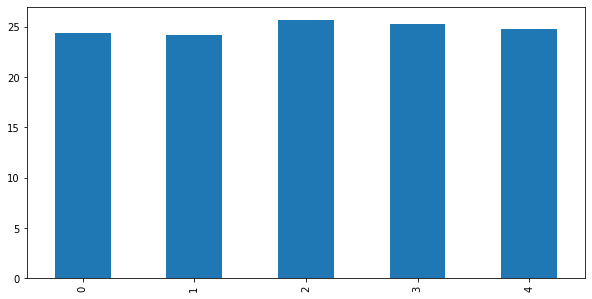

In [55]:
plotGraph(26,[0,3,4,2,1])

In [47]:
SimulationStart()

Estado Inicial: [18.  0.  1.  2.  3.  4.]


Agente executou ação: 2
Novo Estado: [18.  1.  0.  2.  3.  4.]
Recompensa: 0


145873, 0
Old: 0
{"step": 0, "total_reward": 0}
Agente executou ação: 4
Novo Estado: [18.  3.  0.  2.  1.  4.]
Recompensa: 0


145443, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [17.  3.  0.  2.  1.  4.]
Recompensa: 0


137667, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [16.  3.  0.  2.  1.  4.]
Recompensa: 0


129891, 0
Old: 0
Agente executou ação: 4
Novo Estado: [16.  1.  0.  2.  3.  4.]
Recompensa: 0


130321, 0
Old: 0
Agente executou ação: 3
Novo Estado: [16.  2.  0.  1.  3.  4.]
Recompensa: 0


130286, 0
Old: 0
Agente executou ação: 2
Novo Estado: [16.  0.  2.  1.  3.  4.]
Recompensa: 0


130296, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [17.  0.  2.  1.  3.  4.]
Recompensa: 0


138072, 0
Old: 0
Agente executou ação: 2
Novo Estado: [17.  2.  0.  1.  3.  4.]
Recompensa: 0


138062, 0
Old: 0
Agente executou ação: INCREASE
Novo Esta

Novo Estado: [17.  0.  3.  1.  2.  4.]
Recompensa: 0


137862, 0
Old: 0
Agente executou ação: 3
Novo Estado: [17.  1.  3.  0.  2.  4.]
Recompensa: 0


137827, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [18.  1.  3.  0.  2.  4.]
Recompensa: 0


145603, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [17.  1.  3.  0.  2.  4.]
Recompensa: 0


137827, 0
Old: 0
Agente executou ação: 4
Novo Estado: [17.  2.  3.  0.  1.  4.]
Recompensa: 0


137612, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [16.  2.  3.  0.  1.  4.]
Recompensa: 0


129836, 0
Old: 0
Agente executou ação: 2
Novo Estado: [16.  3.  2.  0.  1.  4.]
Recompensa: 0


129831, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [15.  3.  2.  0.  1.  4.]
Recompensa: 0


122055, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [14.  3.  2.  0.  1.  4.]
Recompensa: 0


114279, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [13.  3.  2.  0.  1.  4.]
Recompensa: 0


106503, 0
Old: 0
Agente executou ação: 

Agente executou ação: 5
Novo Estado: [15.  4.  2.  3.  0.  1.]
Recompensa: 0


118060, 0
Old: 0
Agente executou ação: 2
Novo Estado: [15.  2.  4.  3.  0.  1.]
Recompensa: 0


118070, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [16.  2.  4.  3.  0.  1.]
Recompensa: 0


125846, 0
Old: 0
Agente executou ação: 4
Novo Estado: [16.  0.  4.  3.  2.  1.]
Recompensa: 0


126276, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [17.  0.  4.  3.  2.  1.]
Recompensa: 0


134052, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [18.  0.  4.  3.  2.  1.]
Recompensa: 0


141828, 0
Old: 0
Agente executou ação: 5
Novo Estado: [18.  1.  4.  3.  2.  0.]
Recompensa: 0


140533, 0
Old: 0
Agente executou ação: 4
Novo Estado: [18.  2.  4.  3.  1.  0.]
Recompensa: 0


140318, 0
Old: 0.0
Agente executou ação: INCREASE
Novo Estado: [19.  2.  4.  3.  1.  0.]
Recompensa: 0


148094, 0
Old: 0
Agente executou ação: 5
Novo Estado: [19.  0.  4.  3.  1.  2.]
Recompensa: 0


150684, 0
Old: 0
Agente exe

Novo Estado: [17.  0.  3.  4.  1.  2.]
Recompensa: 0


135162, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [18.  0.  3.  4.  1.  2.]
Recompensa: 0


142938, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [17.  0.  3.  4.  1.  2.]
Recompensa: 0


135162, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [18.  0.  3.  4.  1.  2.]
Recompensa: 0


142938, 0
Old: 0.0
Agente executou ação: 5
Novo Estado: [18.  2.  3.  4.  1.  0.]
Recompensa: 0


140348, 0
Old: 0
Agente executou ação: 3
Novo Estado: [18.  4.  3.  2.  1.  0.]
Recompensa: 0


140278, 0
Old: 0
Agente executou ação: 4
Novo Estado: [18.  1.  3.  2.  4.  0.]
Recompensa: 0


140923, 0
Old: 0
Agente executou ação: 5
Novo Estado: [18.  0.  3.  2.  4.  1.]
Recompensa: 0


142218, 0
Old: 0
Agente executou ação: 4
Novo Estado: [18.  4.  3.  2.  0.  1.]
Recompensa: 0


141358, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [17.  4.  3.  2.  0.  1.]
Recompensa: 0


133582, 0
Old: 0
Agente executou ação: 5
Novo Estad

Agente executou ação: 4
Novo Estado: [12.  0.  1.  4.  3.  2.]
Recompensa: 0


96702, 0
Old: 0
Agente executou ação: 2
Novo Estado: [12.  1.  0.  4.  3.  2.]
Recompensa: 0


96697, 0
Old: 0
Agente executou ação: 2
Novo Estado: [12.  0.  1.  4.  3.  2.]
Recompensa: 0


96702, 0
Old: 0
Agente executou ação: 2
Novo Estado: [12.  1.  0.  4.  3.  2.]
Recompensa: 0


96697, 0
Old: 0.0
Agente executou ação: DECREASE
Novo Estado: [11.  1.  0.  4.  3.  2.]
Recompensa: 0


88921, 0
Old: 0
Agente executou ação: 5
Novo Estado: [11.  2.  0.  4.  3.  1.]
Recompensa: 0


87626, 0
Old: 0
Agente executou ação: 4
Novo Estado: [11.  3.  0.  4.  2.  1.]
Recompensa: 0


87411, 0
Old: 0
Agente executou ação: 2
Novo Estado: [11.  0.  3.  4.  2.  1.]
Recompensa: 0


87426, 0
Old: 0
Agente executou ação: 4
Novo Estado: [11.  2.  3.  4.  0.  1.]
Recompensa: 0


86996, 0
Old: 0
Agente executou ação: 4
Novo Estado: [11.  0.  3.  4.  2.  1.]
Recompensa: 0


87426, 0
Old: 0
Agente executou ação: 2
Novo Estado: [11.

Novo Estado: [22.  0.  4.  1.  2.  3.]
Recompensa: 0


175452, 0
Old: 0
Agente executou ação: 4
Novo Estado: [22.  2.  4.  1.  0.  3.]
Recompensa: 0


175022, 0
Old: 0
Agente executou ação: 4
Novo Estado: [22.  0.  4.  1.  2.  3.]
Recompensa: 0


175452, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [21.  0.  4.  1.  2.  3.]
Recompensa: 0


167676, 0
Old: 0
Agente executou ação: DECREASE
Novo Estado: [20.  0.  4.  1.  2.  3.]
Recompensa: 0


159900, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [21.  0.  4.  1.  2.  3.]
Recompensa: 0


167676, 0
Old: 0
Agente executou ação: INCREASE
Novo Estado: [22.  0.  4.  1.  2.  3.]
Recompensa: 0


175452, 0
Old: 0.0
Agente executou ação: 2
Novo Estado: [22.  4.  0.  1.  2.  3.]
Recompensa: 0


175432, 0
Old: 0
Agente executou ação: 3
Novo Estado: [22.  1.  0.  4.  2.  3.]
Recompensa: 0


175537, 0
Old: 0
Agente executou ação: 2
Novo Estado: [22.  0.  1.  4.  2.  3.]
Recompensa: 0


175542, 0
Old: 0
Agente executou ação: 4
Novo Estad

TypeError: list indices must be integers or slices, not numpy.float64